# Satellite-Derived Data Insights into Long-Term Lake Temperature Trends

Production date: 16-12-2025

Produced by: Amaya Camila Trigoso Barrientos (VUB) and Victor Couplet (VUB)

## 🌍 Use case: Analyzing the long-term trend in surface water temperature of Lake Superior

## ❓ Quality assessment question(s)
* **Can satellite data be used to detect the observed increase in summer water temperatures in Lake Superior due to global warming?**

Cases of an increasing trend in lake surface water temperature (LSWT) have been observed in numerous lakes across various regions, including the United States, Europe, and other parts of the world [[1]](https://doi.org/10.1038/s41558-024-02122-y) [[2]](https://climate.copernicus.eu/lake-surface-temperatures). For example, Austin and Colman (2008) found that summer LSWT in Lake Superior increased at a rate of (11±6)×10<sup>-2</sup> °C/year from 1979 to 2006. They attributed this trend to the earlier retreat of winter ice, which causes the positive overturning period to begin sooner, allowing the lake more time to warm. Their analysis was based on measurements from in-situ buoys [[3]](https://doi.org/10.1029/2006GL029021). Later, the Great Lakes Integrated Sciences and Assessments (GLISA) analyzed the annual mean LSWT of Lake Superior between 1995 and 2021. The increasing long-term trend observed by Austin and Colman was not apparent in the period analyzed by GLISA. However, they noted a shift to higher temperatures after 1998 [[4]](https://glisa.umich.edu/lake-superior-retrospective/). The LSWT data analyzed by GLISA was derived from satellite observations and obtained through the NOAA Great Lakes CoastWatch [[5]](https://coastwatch.glerl.noaa.gov/statistics/average-surface-water-temperature-glsea/). Cannon et al. (2024) investigated summer LSWT of Lake Superior using simulation data over a longer time interval (1980-2021), and found a warming trend of (5.2±3.1)×10<sup>-2</sup> °C/year [[6]](https://journals.ametsoc.org/view/journals/clim/37/4/JCLI-D-23-0092.1.xml). 

The objective of this assessment is to evaluate whether the [satellite-lake-water-temperature](https://cds.climate.copernicus.eu/datasets/satellite-lake-water-temperature?tab=overview) dataset from the Climate Data Store (CDS) is suitable for climate change monitoring, using Lake Superior as a case study. We calculated the trend summer LWST for a period of 28 years, from 1995 to 2023, and validated the data and trend computation against in-situ buoy measurements from the NOAA National Buoy Data Center (NBDC) [[7]](https://www.ndbc.noaa.gov/).

## 📢 Quality assessment statement
```{admonition} These are the key outcomes of this assessment
:class: note
* Lake Superior’s summer LSWT trend over 1995–2023, derived from the Copernicus satellite lake water temperature dataset, is slightly negative but not statistically significant.
* The [satellite-lake-water-temperature](https://cds.climate.copernicus.eu/datasets/satellite-lake-water-temperature?tab=overview) dataset shows good agreement with NOAA in-situ buoy observations at selected locations. Differences in summer mean temperatures are partly attributable to the higher temporal sampling of in-situ measurements and to differences in measurement depth, with satellites observing skin temperature and buoys measuring subsurface temperature (≈1 m). Additional discrepancies may result from cloud contamination in the satellite record.
* The dataset is well suited for climate monitoring; however, trend analyses require caution. Elevated summer temperatures in 1998, associated with a strong El Niño event, may obscure longer-term warming signals. Incorporating pre-1995 in-situ observations, where available, would strengthen assessments of long-term trends.
```

## 📋 Methodology

The analysis and results are organized in the following steps, which are detailed in the sections below:

**[](section-1)**

* Satellite lake surface water temperature (LSWT) data are downloaded for the summer months (July–September) over the period 1995–2023.

**[](section-2)**

* The dataset is filtered based on quality flags and lake identification to retain only high-quality observations for Lake Superior.

**[](section-3)**

* A spatially weighted mean LSWT is computed, followed by the calculation of annual summer mean LSWT values.
* The temporal trend is estimated using the Theil–Sen estimator, and its statistical significance is assessed with the Mann–Kendall test.

**[](section-4)** 

* Satellite LSWT data are validated against in-situ measurements from three NOAA-NBDC buoys located in Lake Superior.
* Performance metrics, including mean bias, mean absolute error (MAE), and root mean square error (RMSE), are calculated.
* Buoy observations are resampled to match the less frequent satellite overpass times. Metrics are then recalculated on these time-matched datasets to determine whether differences in summer means arise from sampling frequency or from measurement characteristics (e.g., sensing depth, retrieval uncertainties).
* Finally, LSWT trends derived from buoy data over multiple periods are computed and compared with satellite-based trends and published literature results.

## 📈 Analysis and results

(section-1)=
### 1. Request and download data

#### Import packages

In [21]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import matplotlib.cbook
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import xarray as xr
import pymannkendall as mk
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils
from scipy.stats import linregress
from matplotlib.lines import Line2D
from sklearn.metrics import mean_squared_error

import requests, gzip
from io import StringIO
from tqdm import tqdm

plt.style.use("seaborn-v0_8-notebook")

#### Set variables

In [22]:
# Time
year_start = 1995
year_stop = 2023

# Region
lon_slice = slice(-92.10, -84.80)
lat_slice = slice(46.30, 49.00)

# Variable
varname = "lake_surface_water_temperature"

#### Set the data request

In [23]:
collection_id = "satellite-lake-water-temperature"
Requests = []
for year in range(year_start, year_stop + 1):
    Requests.append(
        {
            "variable": "all",
            "year": [str(year)],
            "month": ["07", "08", "09"],
            "day": [f"{day:02d}" for day in range(1, 32)],
            "version": ["4_5" if year < 2021 else "4_5_2"],
        }
    )

#### Download data

In [24]:
ds = download.download_and_transform(
    collection_id,
    Requests,
    transform_func=utils.regionalise,
    transform_func_kwargs={"lon_slice": lon_slice, "lat_slice": lat_slice},
    chunks={"year": 1},
)

100%|██████████| 29/29 [00:02<00:00, 14.49it/s]


(section-2)=
### 2. Data preprocessing 

We download satellite lake surface temperature data and visualize the water masses over the region spanning 46.30–49.00°N latitude and 92.10–84.80°W longitude. In the dataset, Lake Superior is identified by ID number 2. The locations of the three NOAA buoys used for data comparison are also plotted.

#### Plot lakeid

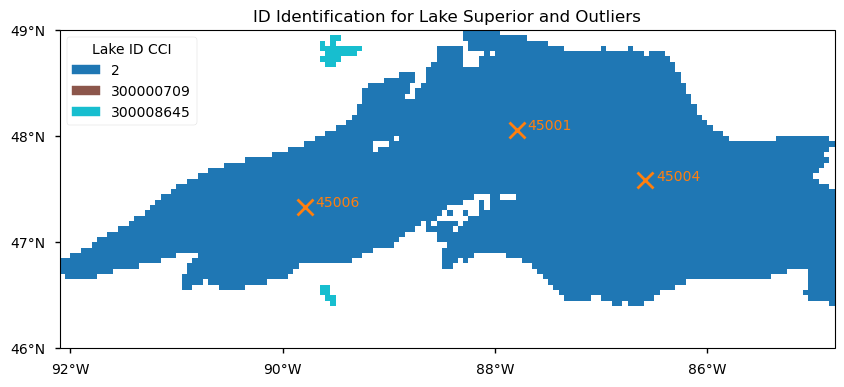

In [25]:
lakeid_data = ds['lakeid_CCI']
lats = ds['latitude']
lons = ds['longitude']

unique_ids = np.unique(lakeid_data.values[~np.isnan(lakeid_data.values)])
cmap = plt.get_cmap('tab10', len(unique_ids))

# ------------------------------------------------------------------
# Buoy coordinates (lon, lat)
buoy_coords = {
    "45006": (-89.793, 47.335),
    "45004": (-86.585, 47.585),
    "45001": (-87.793, 48.061),
}

# ------------------------------------------------------------------
# Plot
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

im = ax.pcolormesh(
    lons,
    lats,
    lakeid_data.isel(time=0),
    cmap=cmap,
    shading="auto",
    transform=ccrs.PlateCarree()
)

# ------------------------------------------------------------------
# Plot buoys
for name, (lon, lat) in buoy_coords.items():
    ax.plot(
        lon, lat,
        marker='x',
        color='C1',
        markersize=12,
        markeredgewidth=2,
        transform=ccrs.PlateCarree(),
        zorder=10
    )
    ax.text(
        lon + 0.1, lat,
        name,
        color='C1',
        fontsize=10,
        transform=ccrs.PlateCarree(),
        zorder=11
    )

# ------------------------------------------------------------------
# Longitude / latitude ticks
ax.set_xticks(np.arange(-92, -84, 2), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(46, 50, 1), crs=ccrs.PlateCarree())

ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

ax.tick_params(labelsize=10)

# ------------------------------------------------------------------
# Legend for lake IDs
legend_handles = [
    mpatches.Patch(color=cmap(i / len(unique_ids)), label=str(int(uid)))
    for i, uid in enumerate(unique_ids)
]

ax.legend(
    handles=legend_handles,
    loc="upper left",
    title="Lake ID CCI",
    frameon=True
)

ax.set_title("ID Identification for Lake Superior and Outliers")

plt.show()


*Figure 1 : Lake Superior identification in the dataset. Locations of the three NOAA-NBDC buoys used for data comparison are shown as orange crosses.*

#### Data filtering

Only observations with quality levels 4 (good) and 5 (best) are retained for analysis.

In [26]:
# Reindex using lakeids and min_quality_level
lakeid = (
    xr.DataArray(np.unique(ds["lakeid_CCI"].values), dims=("lakeid_CCI"))
    .dropna("lakeid_CCI")
    .astype(int)
)
min_quality_level = xr.DataArray([0, 4], dims=("min_quality_level"))
ds = ds.drop_vars("lakeid_CCI").where(ds["lakeid_CCI"] == lakeid)
ds = ds.where(ds["lswt_quality_level"] >= min_quality_level)
ds = ds.assign_coords(lakeid_CCI=lakeid, min_quality_level=min_quality_level)

filtered_ds = ds.sel(lakeid_CCI=2, min_quality_level=4)

(section-3)=
### 3. Summer mean analysis

For each time step, lake surface water temperatures are averaged spatially across Lake Superior, and these values are then averaged over the summer months (July–September). The 1995–2023 trend is estimated using the Theil–Sen estimator, and its statistical significance is assessed with the Mann–Kendall test.

#### Summer mean 


In [27]:
spatial_mean = diagnostics.spatial_weighted_mean(filtered_ds["lake_surface_water_temperature"])
summer_mean = spatial_mean.groupby('time.year').map(diagnostics.time_weighted_mean)

#### Trend estimation

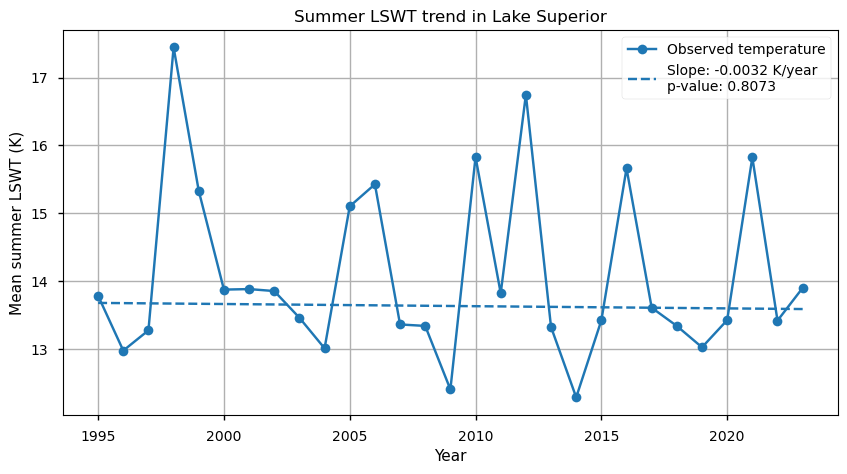

In [28]:
data = summer_mean.values-273.15
years = summer_mean['year'].values

# Run Theil-Sen + Mann-Kendall
result = mk.original_test(data)
slope = result.slope
trend = result.trend
p_value = result.p

# Compute Theil-Sen line for plotting
intercept = np.median(data - slope * np.arange(len(data)))
trend_line = intercept + slope * np.arange(len(data))

# Plot
plt.figure(figsize=(10,5))
plt.plot(years, data, 'o-', label='Observed temperature')
plt.plot(years, trend_line, 'C0--', label=f'Slope: {slope:.4f} K/year\np-value: {p_value:.4f}')
plt.xlabel('Year')
plt.ylabel('Mean summer LSWT (K)')
plt.title('Summer LSWT trend in Lake Superior')
plt.legend()
plt.grid(True)
plt.show()


*Figure 2 : Mean summer LSWT for Lake Superior between 1995 and 2023, and trend estimation.*

The trend line in *Figure 2* shows a slight negative slope of −0.0032 °C yr⁻¹. However, the p-value of 0.81 is well above the common significance threshold of 0.05, indicating that the trend is not statistically significant. This lack of significance may partly reflect the relatively short 28-year period analyzed, as longer time series are typically required to detect meaningful climate trends in large lakes.

At first glance, the absence of a significant warming trend may seem surprising. Previous work [[3]](https://doi.org/10.1029/2006GL029021) reported a significant increase in summer temperatures from 1979 to 2006, and it seems unlikely that summer lake surface temperatures have stabilised since then, given ongoing global warming.

To verify these results, we will compare the satellite data with in-situ buoy measurements.

(section-4)=
### 4. Comparison with NOAA buoy data

The satellite data are compared with in-situ measurements from three NOAA NDBC buoys in Lake Superior [[7]](https://www.ndbc.noaa.gov/). These are the same buoys used in [[3]](https://doi.org/10.1029/2006GL029021), which reported a significant increase in summer temperatures from 1979 to 2006. In-situ data are now available through 2024. The goal of this section is thus to compare satellite and buoy data over 1995–2023 and evaluate whether similar trends are observed in the buoy measurements. 

First, the buoy data are downloaded from the NOAA National Data Buoy Center website [[3]](https://doi.org/10.1029/2006GL029021), which provides data by station and year. We developed a Python script that automatically downloads the data for buoys 45001, 45004, and 45006 for all available years between 1979 and 2024, and combines them into a single, unified dataset.

In [29]:
def parse_noaa_text(text):
    """
    Parse NOAA stdmet text data.

    Args:
        text (str): Raw text from NOAA stdmet file.

    Returns:
        tuple: (columns_list, data_lines_str, header_line_index) or (None, None, None) if no header found.
    """
    lines = text.splitlines()

    # Find header: first non-empty line whose first token contains letters
    header_idx, header = next(
        ((i, ln.lstrip('#').strip()) for i, ln in enumerate(lines)
         if ln.strip() and any(ch.isalpha() for ch in ln.lstrip('#').split()[0])),
        (None, None)
    )

    if header is None:
        return None, None, None

    cols = header.split()
    # Extract data lines (non-empty, non-comment lines after header)
    data_lines = [ln.rstrip() for ln in lines[header_idx + 1:] if ln.strip() and not ln.lstrip().startswith('#')]

    return cols, "\n".join(data_lines), header_idx


def load_noaa_year(station, year, timeout=15):
    """
    Load one year of NOAA stdmet data for a given station.

    Args:
        station (str): NOAA station ID.
        year (int): Year to load.
        timeout (int): Requests timeout in seconds.

    Returns:
        pd.DataFrame: Columns ['datetime', 'WTMP'], or None if no usable data.
    """
    url = f"https://www.ndbc.noaa.gov/data/historical/stdmet/{station}h{year}.txt.gz"
    #print(f"Downloading {url} ...", end=" ")

    try:
        r = requests.get(url, timeout=timeout)
        r.raise_for_status()
        raw = gzip.decompress(r.content).decode("utf-8", errors="replace")
    except Exception as e:
        tqdm.write(f"\n → download error: {e}")
        return None

    cols, data_text, _ = parse_noaa_text(raw)
    if not cols or not data_text.strip():
        print(" → no usable header/data")
        return None

    try:
        df = pd.read_csv(
            StringIO(data_text),
            sep=r"\s+",
            names=cols,
            header=None,
            na_values=["MM", "99.0", "99", "999", "999.0", "9999"],
            comment="#",
            engine="python",
        )
    except Exception as e:
        print(f" → pandas read error: {e}")
        return None

    df.columns = [c.lstrip("#") for c in df.columns]

    # Ensure numeric columns for date/time
    for c in ("YY", "YYYY", "MM", "DD", "hh", "mm"):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Determine proper year
    if "YYYY" in df.columns:
        df["YEAR"] = df["YYYY"]
    elif "YY" in df.columns or "#YY" in df.columns:
        yy_col = "YY" if "YY" in df.columns else "#YY"
        # If any 4-digit year present, treat as full year
        if df[yy_col].dropna().astype(str).str.len().gt(3).any():
            df["YEAR"] = df[yy_col]
        else:
            # 2-digit year: <50 -> 2000s, >=50 -> 1900s
            df["YEAR"] = df[yy_col].apply(lambda x: 2000 + x if x < 50 else 1900 + x)
    else:
        print(" → no recognizable year column")
        return None

    # Ensure minutes exist
    if "mm" not in df.columns:
        df["mm"] = 0

    # Build datetime column
    try:
        dt = pd.to_datetime(
            dict(year=df["YEAR"], month=df["MM"], day=df["DD"], hour=df["hh"], minute=df["mm"]),
            errors="coerce"
        )
    except Exception as e:
        print(f" → datetime conversion error: {e}")
        return None

    # Process WTMP
    if "WTMP" not in df.columns:
        print(" → WTMP column missing, skipping")
        return None
    df["WTMP"] = pd.to_numeric(df["WTMP"], errors="coerce")

    # Build output dataframe and filter invalid/extreme values
    out = pd.DataFrame({"datetime": dt, "WTMP": df["WTMP"]})
    out = out.dropna(subset=["datetime"])
    out = out[out["WTMP"].notna()]
    out = out[(out["WTMP"] > -5) & (out["WTMP"] < 50)]

    #print(f" → loaded {len(out)} rows")
    return out.reset_index(drop=True)


def load_noaa_range(stations, start_year=1979, end_year=2024):
    """
    Load NOAA data for multiple stations and years, with a progress bar.
    Returns a single DataFrame with a MultiIndex (station, datetime) and column 'WTMP'.
    """
    all_data = []
    total_steps = len(stations) * (end_year - start_year + 1)

    with tqdm(total=total_steps, desc="Overall progress") as pbar:
        for station in stations:
            for year in range(start_year, end_year + 1):
                pbar.set_postfix({"station": station, "year": year})
                df = load_noaa_year(station, year)
                if df is not None and not df.empty:
                    df["station"] = station
                    all_data.append(df)
                pbar.update(1)

    if not all_data:
        print("No data loaded for any station.")
        return pd.DataFrame(columns=["WTMP"], index=pd.MultiIndex.from_arrays([[], []], names=("station", "datetime")))

    # Concatenate all data
    full_df = pd.concat(all_data, ignore_index=True)

    # Set MultiIndex (station, datetime)
    full_df.set_index(["station", "datetime"], inplace=True)
    full_df.sort_index(inplace=True)

    print(f"Total rows loaded: {len(full_df)}")
    return full_df

In [30]:
stations = ["45001","45004","45006"]
buoy_data = load_noaa_range(stations, 1979, 2024)


Overall progress:  34%|███▍      | 47/138 [00:16<00:57,  1.57it/s, station=45004, year=1980]


 → download error: 404 Client Error: Not Found for url: https://www.ndbc.noaa.gov/data/historical/stdmet/45004h1979.txt.gz


Overall progress:  67%|██████▋   | 93/138 [00:31<00:27,  1.63it/s, station=45006, year=1980]


 → download error: 404 Client Error: Not Found for url: https://www.ndbc.noaa.gov/data/historical/stdmet/45006h1979.txt.gz


Overall progress:  69%|██████▉   | 95/138 [00:32<00:19,  2.24it/s, station=45006, year=1982]


 → download error: 404 Client Error: Not Found for url: https://www.ndbc.noaa.gov/data/historical/stdmet/45006h1980.txt.gz


Overall progress: 100%|██████████| 138/138 [00:44<00:00,  3.07it/s, station=45006, year=2024]

Total rows loaded: 958592


Second, the buoy data are averaged over the summer months, and each buoy is compared to the summer mean temperature of the nearest satellite pixel corresponding to its location (see *Figure 3*).

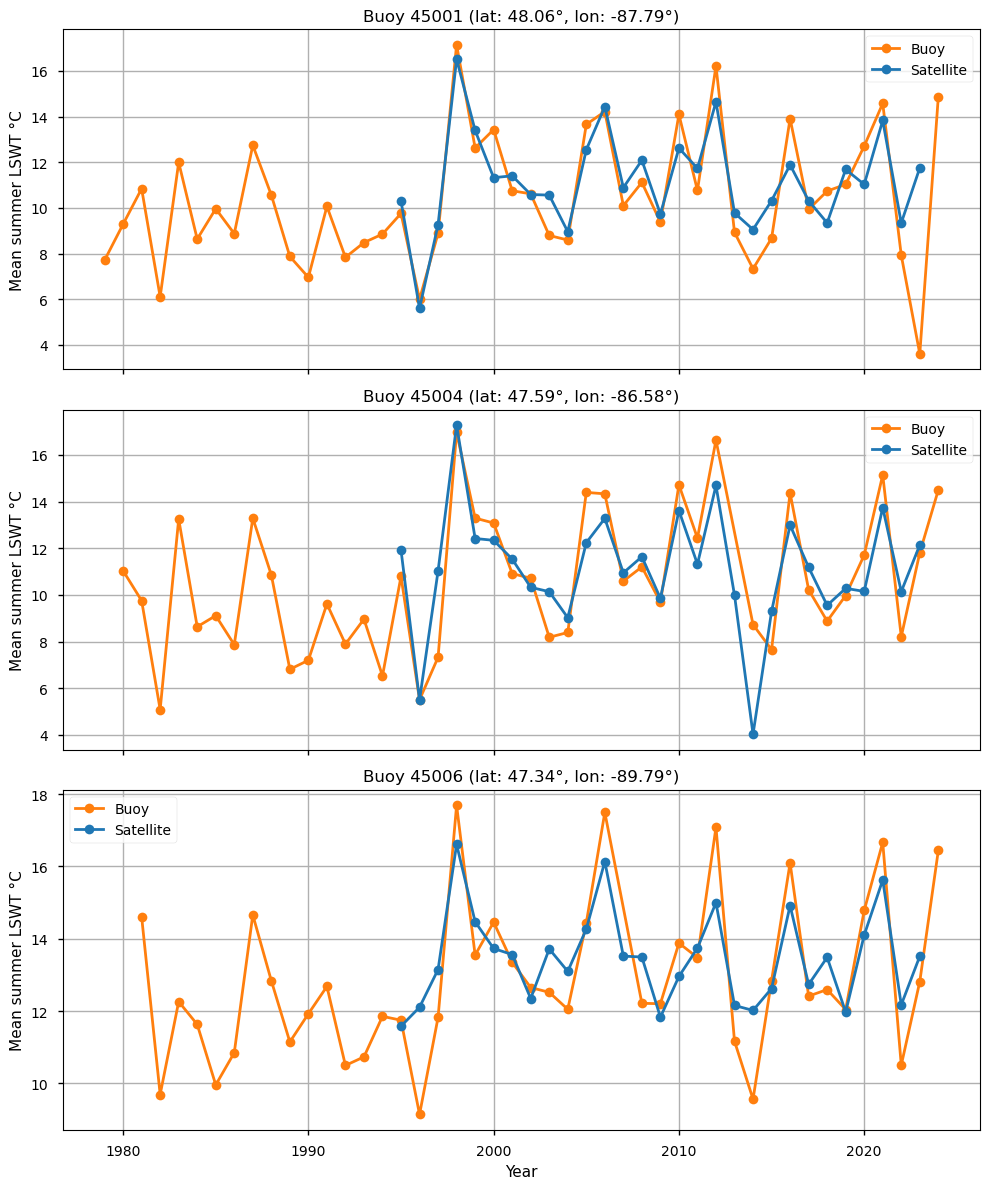

In [31]:
# Compare buoy and satellite summer mean temperatures

summer_months = [7, 8, 9]  # JAS


buoy_df = (
    buoy_data
    .reset_index()
    .assign(
        year=lambda d: d["datetime"].dt.year,
        month=lambda d: d["datetime"].dt.month,
    )
)

summer_buoy = (
    buoy_df
    .loc[buoy_df["month"].isin(summer_months)]
    .groupby(["station", "year"], as_index=False)["WTMP"]
    .mean()
)

# Extract nearest-neighbor satellite temperature at each buoy position,
# convert from Kelvin to Celsius, and compute summer annual means

sat_records = []

for station, (lon, lat) in buoy_coords.items():

    # Nearest satellite grid cell to buoy location
    ts = (
        filtered_ds[varname]
        .sel(longitude=lon, latitude=lat, method="nearest")
    )

    # Convert from Kelvin to Celsius
    ts_C = ts - 273.15

    # Restrict to summer months
    ts_summer = ts_C.sel(time=ts_C["time.month"].isin(summer_months))

    # Compute annual summer mean
    ts_summer_mean = (
        ts_summer
        .groupby("time.year")
        .mean("time")
        .to_dataframe(name="sat_WTMP")
        .reset_index()
    )

    ts_summer_mean["station"] = station
    sat_records.append(ts_summer_mean)

# Concatenate all stations into a single reusable table
sat_summer = (
    pd.concat(sat_records, ignore_index=True)
      .sort_values(["station", "year"])
)

# Plot comparison 

stations = summer_buoy["station"].unique()

fig, axes = plt.subplots(
    nrows=len(stations),
    ncols=1,
    figsize=(10, 12),
    sharex=True,
)

for ax, st in zip(axes, stations):

    s_buoy = summer_buoy.loc[summer_buoy["station"] == st]
    s_sat  = sat_summer.loc[sat_summer["station"] == st]

    ax.plot(
        s_buoy["year"],
        s_buoy["WTMP"],
        marker="o",
        linewidth=2,
        label="Buoy",
        color='C1'
    )

    ax.plot(
        s_sat["year"],
        s_sat["sat_WTMP"],
        marker="o",
        linewidth=2,
        label="Satellite",
        color ='C0'
    )

    lon, lat = buoy_coords[st]  # get coordinates
    ax.set_title(f"Buoy {st} (lat: {lat:.2f}°, lon: {lon:.2f}°)")
    ax.set_ylabel("Mean summer LSWT °C")
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()

*Figure 3: Mean summer LSWT for three Lake Superior buoys, compared to the mean summer LSWT from satellite data at the nearest pixel locations.*  

We observe that the satellite data are generally close to the buoy measurements; for instance, the 1998 peak in summer LSWT is well captured. To further quantify the differences between satellite and buoy data, we compute the mean bias, mean absolute error (MAE), and root mean square error (RMSE).

In [32]:
def compute_sst_validation_metrics(df):
    """
    Compute satellite-vs-buoy SST validation metrics.

    Expects columns: ['station', 'year', 'buoy', 'sat'].

    Returns:
        pd.DataFrame with per-station metrics and a final 'ALL' row
        containing overall metrics.
    """

    rows = []

    # ---- Helper to compute metrics for any subset ----
    def metrics(sub):
        sat = sub["sat"].values
        buoy = sub["buoy"].values
        diff = sat - buoy

        bias = diff.mean()
        mae = np.mean(np.abs(diff))
        rmse = np.sqrt(mean_squared_error(buoy, sat))

        return {
            "n_samples": len(sub),
            "bias": bias,
            "MAE": mae,
            "RMSE": rmse,
        }

    # ---- Per-station metrics ----
    for st, sub in df.groupby("station"):
        row = {"station": st}
        row.update(metrics(sub))
        rows.append(row)

    # ---- Overall metrics (all stations pooled) ----
    overall = {"station": "ALL"}
    overall.update(metrics(df))
    rows.append(overall)

    return pd.DataFrame(rows)


In [33]:
df_diff = (
    summer_buoy
    .rename(columns={"WTMP": "buoy"})
    .merge(
        sat_summer.rename(columns={"sat_WTMP": "sat"}),
        on=["station", "year"],
        how="inner",
    )
)

metrics_df = compute_sst_validation_metrics(df_diff)

pd.options.display.float_format = '{:.2f}'.format

display(metrics_df)

,station,n_samples,bias,MAE,RMSE
0,45001,29,0.32,1.23,1.88
1,45004,28,-0.12,1.20,1.58
2,45006,28,0.21,0.95,1.18
3,ALL,85,0.14,1.13,1.58


Overall, the satellite data exhibit a small warm bias of 0.14 °C. However, the MAE and RMSE are relatively large, at 1.13 °C and 1.58 °C, respectively. A likely source of error is the difference in sampling frequency: the satellite dataset provides roughly one measurement per day, whereas the buoys record about 30 measurements per day. In addition, some days are missing in the satellite data, possibly due to cloud cover. To explore this further, we focus on summer 2016 for buoy 45001 (*see Figure 4*).

We observe that only two satellite observations are available between late July and mid-August, a particularly warm period, whereas the buoy provides continuous coverage throughout the three summer months (*Figure 4, top pannel*). This limited satellite data availability likely contributes to the satellite-derived mean summer LSWT being approximately 2 °C lower than the buoy-based mean. Indeed, when restricting the buoy data to the 31 measurements closest in time to the 31 satellite observations during summer 2016, the resulting mean LSWT is very similar to the satellite-derived value (*Figure 4, bottom pannel*). 

In [34]:
def get_matched_buoy_sat(buoy_data, filtered_ds, varname, buoy_coords,
                          summer_months=[7, 8, 9], tolerance=pd.Timedelta('1h')):
    """
    Match buoy and satellite time series by timestamp within a tolerance for multiple stations.

    Args:
        buoy_data (pd.DataFrame): Buoy data with MultiIndex (station, datetime)
        filtered_ds (xarray.DataArray): Satellite data (Kelvin)
        varname (str): Name of variable in filtered_ds
        buoy_coords (dict): station -> (lat, lon)
        summer_months (list): List of summer months to consider
        tolerance (pd.Timedelta): Maximum allowed time difference for matching

    Returns:
        pd.DataFrame: Long-form DataFrame with columns
                      ['station', 'time', 'buoy', 'sat']
                      containing matched values for each station/time.
    """
    records = []

    # Flatten buoy data and add year/month
    df_buoy = buoy_data.reset_index()
    df_buoy['year'] = df_buoy['datetime'].dt.year
    df_buoy['month'] = df_buoy['datetime'].dt.month

    years = sorted(df_buoy['year'].unique())

    for st, (lon, lat) in buoy_coords.items():
        # Satellite at buoy location
        ts_sat = filtered_ds[varname].sel(latitude=lat, longitude=lon, method='nearest') - 273.15
        df_sat = ts_sat.to_dataframe(name='sat').dropna().reset_index()
        df_sat['year'] = df_sat['time'].dt.year
        df_sat['month'] = df_sat['time'].dt.month
        df_sat_summer = df_sat[df_sat['month'].isin(summer_months)].sort_values('time')

        # Buoy summer series
        df_buoy_st = df_buoy[(df_buoy['station'] == st) & (df_buoy['month'].isin(summer_months))]
        df_buoy_st = df_buoy_st[['datetime', 'WTMP']].sort_values('datetime')

        # Match satellite and buoy points year by year
        for yr in years:
            df_sat_year = df_sat_summer[df_sat_summer['year'] == yr]
            df_buoy_year = df_buoy_st[df_buoy_st['datetime'].dt.year == yr]
           
            if len(df_sat_year) > 0 and len(df_buoy_year) > 0:
                matched = pd.merge_asof(
                    df_sat_year,
                    df_buoy_year.rename(columns={'datetime': 'time'}),
                    on='time',
                    direction='nearest',
                    tolerance=tolerance
                ).dropna()

                for _, row in matched.iterrows():
                    records.append({
                        'station': st,
                        'time': row['time'],
                        'buoy': row['WTMP'],
                        'sat': row['sat']
                    })
        
    df_matched = pd.DataFrame(records)
    return df_matched


In [35]:
df_matched = get_matched_buoy_sat(
    buoy_data=buoy_data,
    filtered_ds=filtered_ds,
    varname=varname,
    buoy_coords=buoy_coords,
    summer_months=[7, 8, 9],
    tolerance=pd.Timedelta('1h')
)

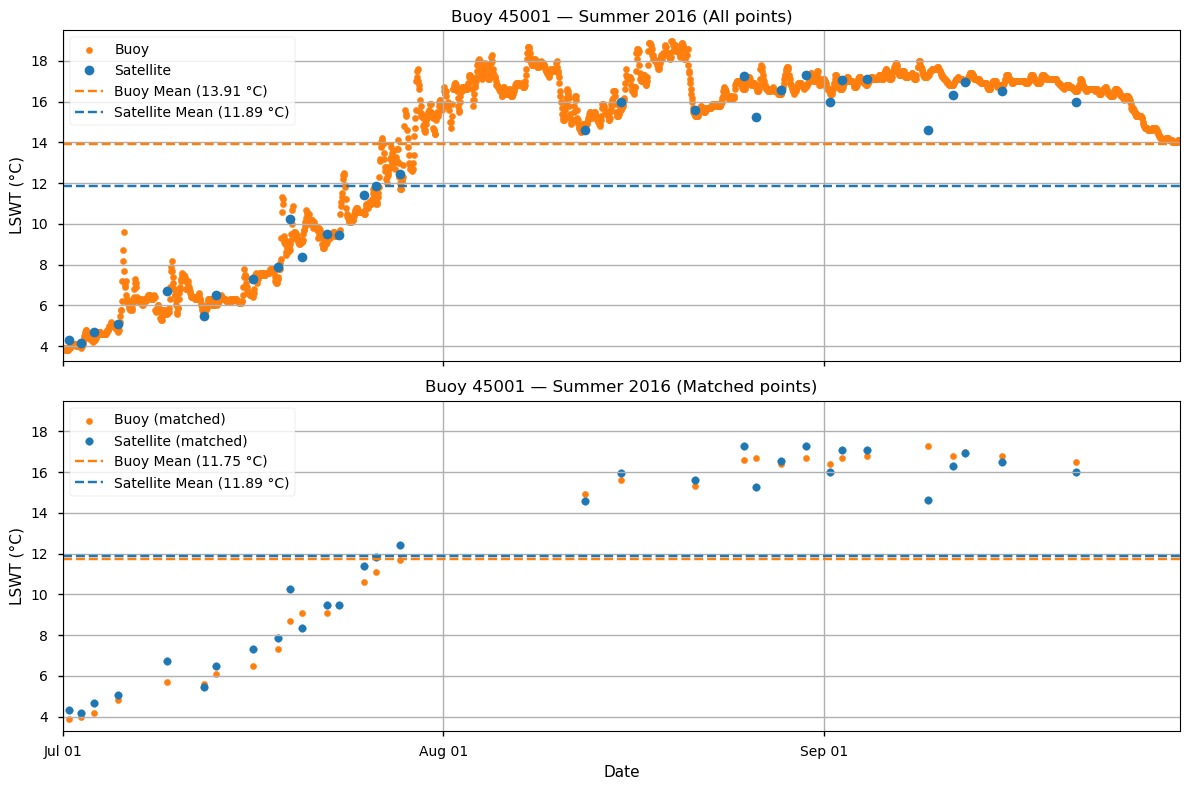

In [36]:
# --------------------------------------------------
# User inputs
# --------------------------------------------------
year = 2016
station = "45001"
summer_months = [7, 8, 9]

# Station coordinates
lon_pixel, lat_pixel = buoy_coords[station]

# --------------------------------------------------
# 1. All points (summer) for the station/year
# --------------------------------------------------
# Buoy: all summer points
df_buoy_all = buoy_data.reset_index()
df_buoy_all = df_buoy_all[
    (df_buoy_all['station'] == station) &
    (df_buoy_all['datetime'].dt.year == year) &
    (df_buoy_all['datetime'].dt.month.isin(summer_months))
].set_index('datetime')

# Satellite: all summer points at pixel
ts_sat_all = (
    filtered_ds[varname]
    .sel(latitude=lat_pixel, longitude=lon_pixel, method='nearest')
    .sel(time=filtered_ds['time.year'] == year)
)
ts_sat_all = ts_sat_all.sel(time=ts_sat_all['time.month'].isin(summer_months)) - 273.15

# Means for all points
mean_buoy_all = df_buoy_all['WTMP'].mean()
mean_sat_all = ts_sat_all.mean().compute().values

# --------------------------------------------------
# 2. Matched points from df_matched
# --------------------------------------------------
df_st_matched = df_matched[
    (df_matched['station'] == station) &
    (df_matched['time'].dt.year == year) &
    (df_matched['time'].dt.month.isin(summer_months))
].sort_values('time')

mean_buoy_matched = df_st_matched['buoy'].mean()
mean_sat_matched = df_st_matched['sat'].mean()

# --------------------------------------------------
# 3. Shared y-axis limits
# --------------------------------------------------
ymin = min(df_buoy_all['WTMP'].min(), ts_sat_all.min().compute(),
           df_st_matched['buoy'].min(), df_st_matched['sat'].min())
ymax = max(df_buoy_all['WTMP'].max(), ts_sat_all.max().compute(),
           df_st_matched['buoy'].max(), df_st_matched['sat'].max())
pad = 0.5
ylim = (ymin - pad, ymax + pad)

# --------------------------------------------------
# 4. Plot
# --------------------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# ---- Date formatting ----
locator = mdates.MonthLocator()
formatter = mdates.DateFormatter("%b %d")

# -------------------------
# Top subplot: all summer points
# -------------------------
axes[0].scatter(df_buoy_all.index, df_buoy_all['WTMP'], color='C1', s=20, label='Buoy')
ts_sat_all.plot(ax=axes[0], marker='o',linestyle='none', color='C0', label='Satellite')

axes[0].axhline(mean_buoy_all, color='C1', linestyle='--', label=f'Buoy Mean ({mean_buoy_all:.2f} °C)')
axes[0].axhline(mean_sat_all, color='C0', linestyle='--', label=f'Satellite Mean ({mean_sat_all:.2f} °C)')

axes[0].set_title(f"Buoy {station} — Summer {year} (All points)")
axes[0].set_ylabel("LSWT (°C)")
axes[0].set_xlabel("")
axes[0].set_ylim(ylim)
axes[0].grid(True)
axes[0].legend(loc='upper left')

# -------------------------
# Bottom subplot: matched points only
# -------------------------
axes[1].scatter(df_st_matched['time'], df_st_matched['buoy'], color='C1', s=20, label='Buoy (matched)')
axes[1].scatter(df_st_matched['time'], df_st_matched['sat'], color='C0', s=30, marker='o', label='Satellite (matched)')

axes[1].axhline(mean_buoy_matched, color='C1', linestyle='--', label=f'Buoy Mean ({mean_buoy_matched:.2f} °C)')
axes[1].axhline(mean_sat_matched, color='C0', linestyle='--', label=f'Satellite Mean ({mean_sat_matched:.2f} °C)')

axes[1].set_title(f"Buoy {station} — Summer {year} (Matched points)")
axes[1].set_ylabel("LSWT (°C)")
axes[1].set_xlabel("Date")
axes[1].set_ylim(ylim)
axes[1].grid(True)
axes[1].legend(loc='upper left')

# ---- Shared x-axis formatting ----
axes[1].xaxis.set_major_locator(locator)
axes[1].xaxis.set_major_formatter(formatter)
axes[1].set_xlim(pd.Timestamp(f"{year}-07-01"), pd.Timestamp(f"{year}-09-30"))

plt.tight_layout()
plt.show()


*Figure 4 : Comparison of buoy and satellite measurements used to compute the 2016 mean summer LSWT at the location of buoy 45001.* 

This time-matching procedure is repeated for each buoy and year. Specifically, each satellite observation is paired with the nearest buoy measurement in time, provided that the time difference is less than the specified tolerance (default: 1 hour).  

The mean summer LSWT computed from the successfully time-matched satellite–buoy pairs are compared in *Figure 5*. To further quantify differences between the time-matched satellite and buoy data, we compute the mean bias, mean absolute error (MAE), and root mean square error (RMSE).

In [37]:
# Compute summer mean per year for each station
df_diff_matched = (
    df_matched
    .assign(year=lambda d: d['time'].dt.year)
    .groupby(['station', 'year'])
    .mean()
    .reset_index()
)

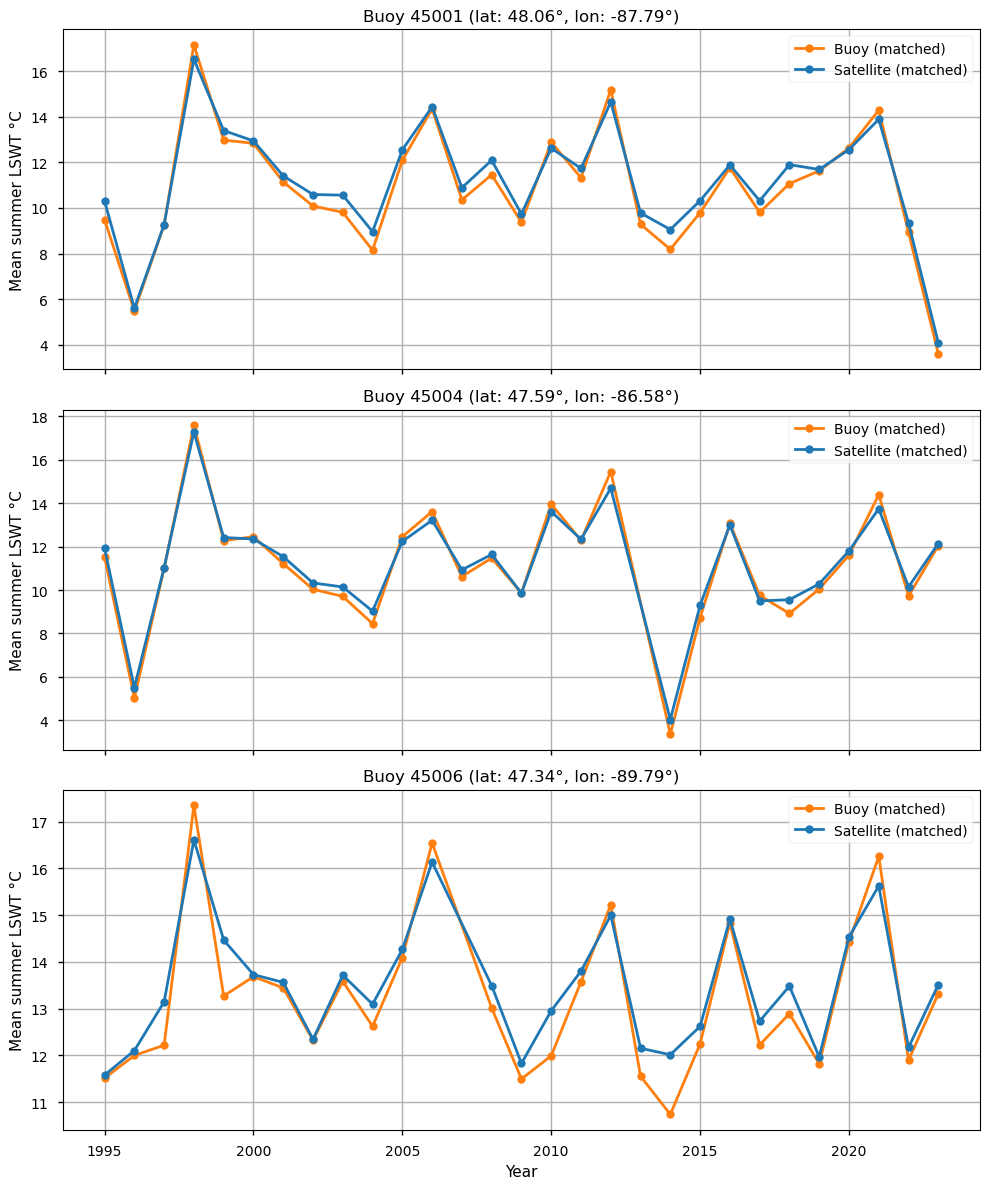

In [38]:
stations = df_diff_matched['station'].unique()

fig, axes = plt.subplots(nrows=len(stations), ncols=1, figsize=(10, 12), sharex=True)

for ax, st in zip(axes, stations):
    df_st = df_diff_matched[df_diff_matched['station'] == st].sort_values('year')

    # Plot buoy data with cross marker
    ax.plot(df_st['year'], df_st['buoy'],
            marker='o', color='C1', linewidth=2, label='Buoy (matched)', markersize=6)

    # Plot satellite data with circle marker
    ax.plot(df_st['year'], df_st['sat'],
            marker='o', color='C0', linewidth=2, label='Satellite (matched)', markersize=6)

    lon, lat = buoy_coords[st]  # get coordinates
    ax.set_title(f"Buoy {st} (lat: {lat:.2f}°, lon: {lon:.2f}°)")
    ax.set_ylabel("Mean summer LSWT °C")
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


*Figure 5: Mean summer LSWT from satellite data compared to buoy data using only successfully time-matched satellite–buoy pairs.*

In [39]:
metrics_df_matched = compute_sst_validation_metrics(df_diff_matched)
display(metrics_df_matched)

,station,n_samples,bias,MAE,RMSE
0,45001,29,0.30,0.43,0.50
1,45004,28,0.10,0.33,0.39
2,45006,28,0.26,0.41,0.53
3,ALL,85,0.22,0.39,0.48


Overall, the satellite data exhibit a small warm bias of 0.22 °C relative to the time-matched buoy observations, slightly larger than the bias obtained when using all available data to compute summer means (0.14 °C). In contrast, the MAE and RMSE are substantially reduced, at 0.39 °C and 0.48 °C, respectively (compared to 1.13 °C and 1.58 °C). This indicates that a large fraction of the difference between the LSWT means shown in *Figure 3* (computed using all data) is attributable to the lower sampling frequency and limited temporal availability of the satellite observations, while individual satellite measurements are comparatively precise. The remaining discrepancies with buoy data are likely due to fundamental measurement differences: satellites measure the lake skin temperature, whereas buoys measure subsurface temperature (typically at ~1 m depth). Depending on atmospheric and lake conditions (e.g., wind and stratification), these measurements can differ. In addition, satellite retrievals may be affected by cloud contamination.

#### Estimation of linear trends

Using all the available buoy data, we estimate linear trends for three periods: 1979–2006, 1995–2023, and 1979–2023 (Figure 6). These are compared with trends derived from satellite data and with previously published results. 

For 1979–2006, the three buoys show warming trends of 0.108 °C/year, 0.098 °C/year, and 0.100 °C/year. Unsurprisingly, these values are consistent with the 0.11 ± 0.06 °C/year estimate reported in [[3]](https://doi.org/10.1029/2006GL029021), which used the same buoy dataset. The associated p-values are relatively small (0.10, 0.30, and 0.07) but fall short of the conventional 0.05 significance threshold, likely due to the limited number of observations.

For 1995-2023, the three buoys show diverging trends of -0.013 °C/year, 0.035 °C/year, and 0.014 °C/year, with large associated p-values ($\geq$0.8), indicating that none of these trends are significant. Satellite-derived trends at the corresponding buoy locations (0.003 °C/year, −0.032 °C/year, and −0.004 °C/year) display the same qualitative behavior: diverging and non-significant. These results are consistent with those in *Figure 2* based on spatially averaged satellite data, and with previous analyses [[4]](https://glisa.umich.edu/lake-superior-retrospective/), confirming the absence of a significant summer LSWT warming trend over this period.

For 1979–2023, the three buoys show warming trends of 0.048 °C/year, 0.061 °C/year, and 0.044 °C/year, with p-values just above the conventional 0.05 significance threshold. These results are consistent with [[6]](https://journals.ametsoc.org/view/journals/clim/37/4/JCLI-D-23-0092.1.xml), which reported a warming trend of 0.052±0.031°C/year for 1980-2021 based on simulation data.   


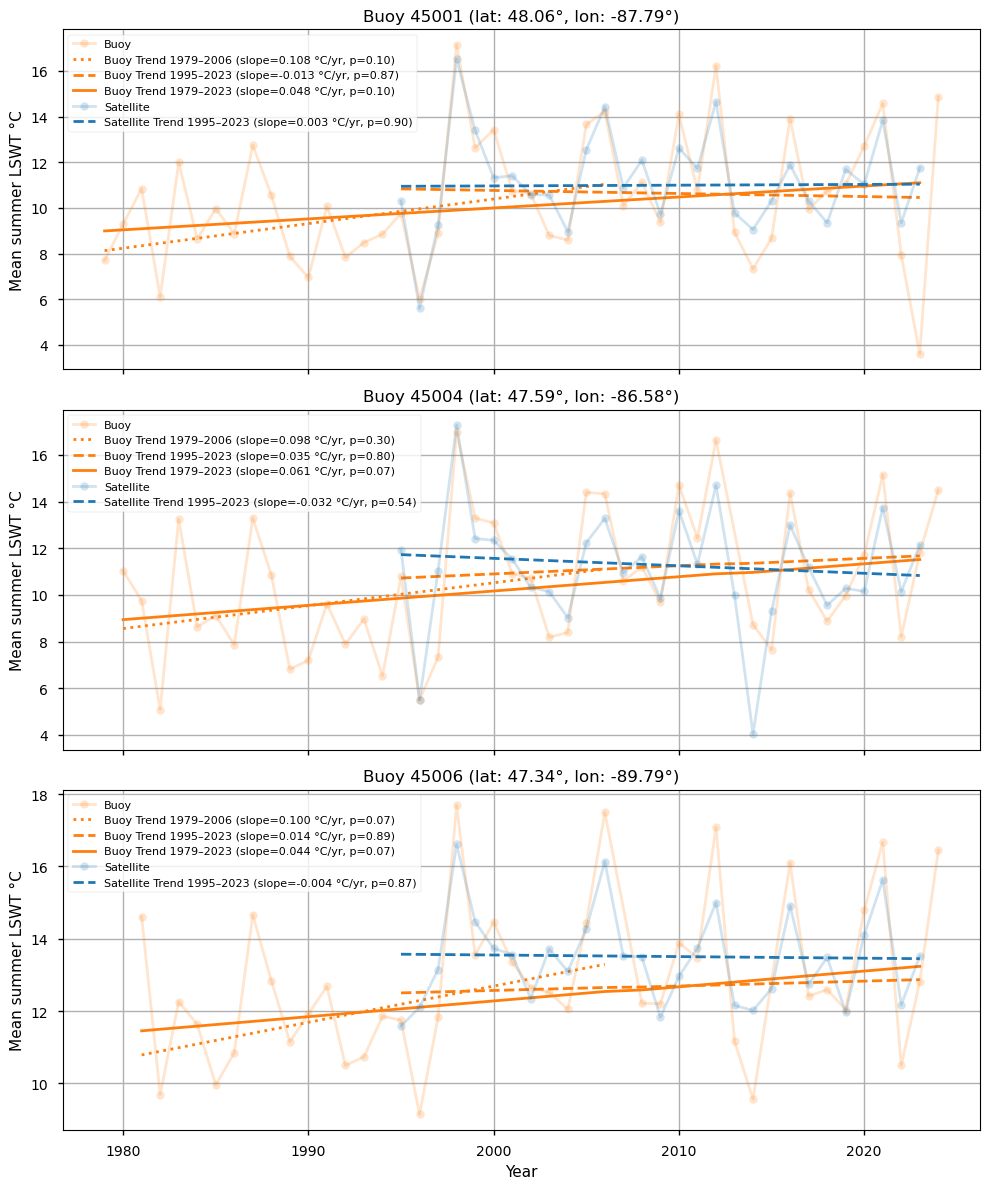

In [40]:
# --------------------------------------------------
# Adjustable line transparency
# --------------------------------------------------
LINE_ALPHA = 0.2

# Buoy trend periods
periods_buoy = [
    (1979, 2006, "1979–2006", "dotted"),
    (1995, 2023, "1995–2023", "dashed"),
    (1979, 2023, "1979–2023", "solid")
]

# Satellite trend period
period_sat = (1995, 2023)

# --------------------------------------------------
# Helper function to plot series + trend
# --------------------------------------------------
def plot_series_with_trend(ax, years, values, label, color, line_alpha=0.2, periods=None, linestyle="-"):
    """Plot a series with markers and optional trend lines."""
    line, = ax.plot(
        years, values,
        linestyle=linestyle,
        linewidth=2,
        color=color,
        alpha=line_alpha,
        marker="o",
        markerfacecolor=color,
        markeredgecolor=color,
        markersize=6,
        label=label
    )

    # Add trends if periods provided
    if periods is not None:
        for start, end, period_label, ls in periods:
            mask = (years >= start) & (years <= end)
            if mask.sum() < 3:
                continue
            data_sel = values[mask]
            result = mk.original_test(data_sel)
            slope = result.slope
            trend_line = np.median(data_sel - slope * np.arange(len(data_sel))) + slope * np.arange(len(data_sel))
            ax.plot(
                years[mask],
                trend_line,
                linestyle=ls,
                linewidth=2,
                color=color,
                label=f"{label} Trend {period_label} (slope={slope:.3f} °C/yr, p={result.p:.2f})"
            )

# --------------------------------------------------
# Plotting
# --------------------------------------------------
stations = summer_buoy['station'].unique()
fig, axes = plt.subplots(nrows=len(stations), ncols=1, figsize=(10, 12), sharex=True)

for ax, st in zip(axes, stations):

    # ---- Buoy summer means ----
    s_buoy = summer_buoy[summer_buoy['station'] == st].sort_values('year')
    plot_series_with_trend(
        ax,
        s_buoy['year'].values,
        s_buoy['WTMP'].values,
        label='Buoy',
        color='C1',
        line_alpha=LINE_ALPHA,
        periods=periods_buoy
    )

    # ---- Satellite summer means ----
    s_sat = sat_summer[sat_summer['station'] == st].sort_values('year')
    plot_series_with_trend(
        ax,
        s_sat['year'].values,
        s_sat['sat_WTMP'].values,
        label='Satellite',
        color='C0',
        line_alpha=LINE_ALPHA,
        periods=[(*period_sat, f"{period_sat[0]}–{period_sat[1]}", "--")]
    )

    # ---- Axes settings ----
    lon, lat = buoy_coords[st]  # get coordinates
    ax.set_title(f"Buoy {st} (lat: {lat:.2f}°, lon: {lon:.2f}°)")
    ax.set_ylabel("Mean summer LSWT °C")
    ax.grid(True)
    ax.legend(fontsize=8)

axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


*Figure 6: Time series of mean summer LSWT for buoy and satellite observations at each buoy location. Semi-transparent lines show summer means, and overlaid trend lines (dotted, dashed, or solid) indicate linear trends for different periods, with slope and p-values reported. Trends were estimated using the Theil-Sen method  in combination with the Mann-Kendall test for statistical significance.*

#### Discussion

Lake Superior’s summer LSWT trend over 1995–2023, derived from the Copernicus [satellite-lake-water-temperature](https://cds.climate.copernicus.eu/datasets/satellite-lake-water-temperature?tab=overview) dataset, is slightly negative but not statistically significant. Although this initially seemed surprising given sustained global warming, the result was confirmed using in-situ buoy data.

Overall, the satellite data shows good agreement with buoy measurements. Differences in computed summer means primarily arise from the lower temporal sampling and occasional missing satellite observations, but the systematic bias is small. This indicates that the satellite-lake-water-temperature dataset is suitable for analyzing summer LSWT trends in Lake Superior. However, no significant warming trend is observed over the 1995–2023 period.

One possible explanation is the unusually high summer temperatures in 1998, associated with a strong El Niño event early in the satellite record. This may have contributed to the relatively large warming trend reported for 1979–2006 [[3]](https://doi.org/10.1029/2006GL029021) and simultaneously obscured longer-term warming signals in the 1995–2023 period. Incorporating pre-1995 in-situ observations, where available, would improve assessments of long-term trends. Indeed, when considering the full buoy record, a near-significant warming trend of ~0.05 °C/year is observed over 1979–2023.

## ℹ️ If you want to know more

* Farina, G., Thiem, H. (2024) [Several Great Lakes experience record-warm water temperatures heading into winter](https://www.climate.gov/news-features/event-tracker/several-great-lakes-experience-record-warm-water-temperatures-heading#). Climate.gov
*  [NOAA CoastWatch: Great Lakes Node](https://coastwatch.glerl.noaa.gov/statistics/average-surface-water-temperature-glsea/)

### Key resources

Dataset documentation:
* [LSWT v4.5: Product User Guide and Specification (PUGS)](https://confluence.ecmwf.int/pages/viewpage.action?pageId=348800177)

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [B-Open](https://www.bopen.eu/)

### References

List the references used in the Notebook here.


* [[1]](https://doi.org/10.1038/s41558-024-02122-y) Wang, X., Shi, K., Qin, B. et al. (2024). Disproportionate impact of atmospheric heat events on lake surface water temperature increases. Nat. Clim. Chang.
* [[2]](https://climate.copernicus.eu/lake-surface-temperatures) Copernicus (2018). Lake surface temperatures. Climate Change Service.
* [[3]](https://doi.org/10.1029/2006GL029021) Jay A. Austin, Steven M. Colman (2007). Lake Superior summer water temperatures are increasing more rapidly than regional air temperatures: A positive ice-albedo feedback. Geophysical Research Letters Volume 34, Issue 6. 
* [[4]](https://glisa.umich.edu/lake-superior-retrospective/) GLISA (2024). Lake Superior Retrospective.
* [[5]](https://coastwatch.glerl.noaa.gov/statistics/average-surface-water-temperature-glsea/) NOAA CoastWatch Great Lakes Regional Node (2024). Average Surface Water Temperature (GLSEA).
* [[6]](https://journals.ametsoc.org/view/journals/clim/37/4/JCLI-D-23-0092.1.xml)  Cannon, D., Wang, J., Fujisaki-Manome, A., Kessler, J., Ruberg, S., & Constant, S. (2024). Investigating Multidecadal Trends in Ice Cover and Subsurface Temperatures in the Laurentian Great Lakes Using a Coupled Hydrodynamic–Ice Model. Journal of Climate, 37(4), 1249-1276.
* [[7]](https://www.ndbc.noaa.gov/) NOAA National Buoy Data Centre.
